In [3]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql import SparkSession
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import *
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import logging
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import os
import matplotlib.pyplot as plt
plt.style.use('ggplot')

spark = SparkSession.builder.master("local[1]")\
          .appName("sunshine_v2")\
          .getOrCreate()

In [2]:
metrics = pd.read_csv("/Users/youssouf/Documents/simboxv2/metrics_predictions.csv", sep = ";")
metrics.head()

,DATE,COMMUN,FRA,SUNSHINE,FILTRE SOS SUNSHINE,COMMUN FILTRE SOS
0,20211001,139,143,796511,521318,125
1,20211002,131,133,762749,491809,121
2,20211003,161,162,741531,477767,140
3,20211004,123,124,799808,526221,107
4,20211005,150,154,747373,491025,131


### Plots

In [10]:
metrics["DATE"] = metrics["DATE"].apply(str)

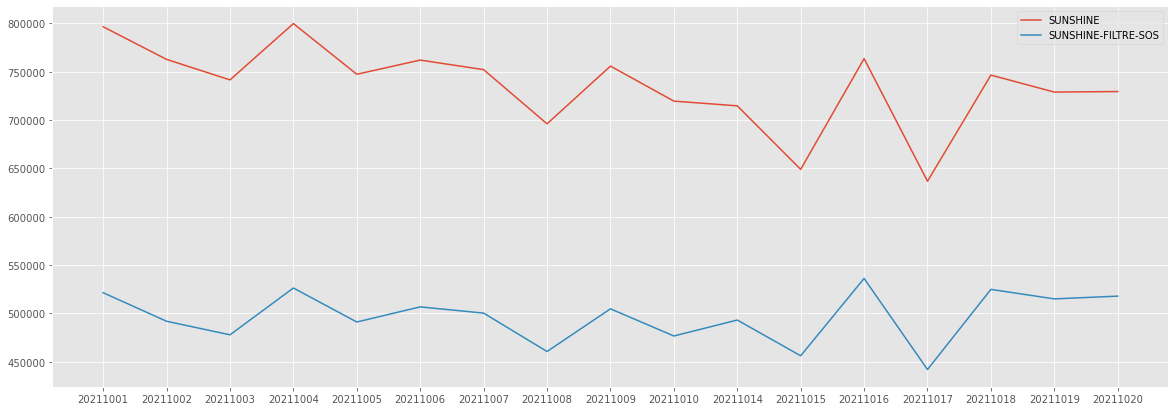

In [11]:
x = metrics["DATE"]
y4 = metrics["SUNSHINE"]
y5 = metrics["FILTRE SOS SUNSHINE"]

# Figure Size
fig = plt.figure(figsize =(20, 7))
plt.plot(x, y4)
plt.plot(x, y5)
plt.legend(["SUNSHINE", "SUNSHINE-FILTRE-SOS"])

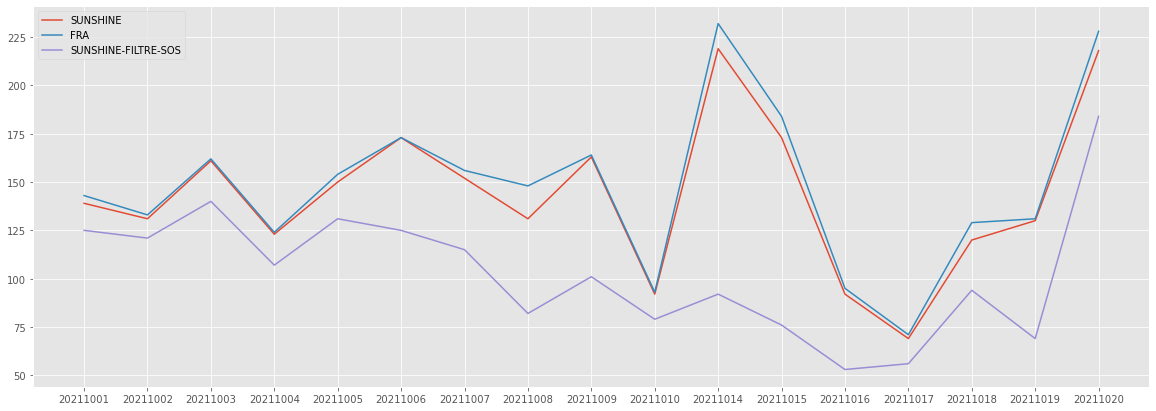

In [12]:
x = metrics["DATE"]
y1 = metrics["COMMUN"]
y2 = metrics["FRA"]
y3 = metrics["COMMUN FILTRE SOS"]

# Figure Size
fig = plt.figure(figsize =(20, 7))
plt.plot(x, y1)
plt.plot(x, y2)
plt.plot(x, y3)
plt.legend(["SUNSHINE", "FRA", "SUNSHINE-FILTRE-SOS"])

### Analysis of numbers anti-left

#### df_left_anti_detected_day

In [24]:
path = "/Users/youssouf/Downloads/trafic_left_anti_102021.csv"
df_left_anti_detected_day =  spark.read \
                .option("delimiter", ";") \
                .option("header", True) \
                .csv(path)

cols = [i.lower() for i in df_left_anti_detected_day.columns]
df_left_anti_detected_day = df_left_anti_detected_day.toDF(*(c for c in cols))
df_left_anti_detected_day = df_left_anti_detected_day.withColumn("date_appel", date_format(to_date(col("date_appel"), "dd/MM/yyyy"), "yyyyMMdd")) 

df_left_anti_detected_day.show(5)

+----------+-------------+------+
|date_appel|       msisdn|call_0|
+----------+-------------+------+
|  20211002|2250769163624|    in|
|  20211002|2250787277173|    in|
|  20211002|2250788695526|    in|
|  20211005|2250759952452|    in|
|  20211006|2250700474992|    in|
+----------+-------------+------+
only showing top 5 rows



In [16]:
#df_left_anti_detected_day = df_left_anti_detected_day.filter(col("date_appel") == "20211002")
#df_left_anti_detected_day.show(5)


+----------+-------------+------+
|date_appel|       msisdn|call_0|
+----------+-------------+------+
|  20211002|2250769163624|    in|
|  20211002|2250787277173|    in|
|  20211002|2250788695526|    in|
|  20211002|2250704655556|   out|
|  20211002|2250704657169|   out|
+----------+-------------+------+
only showing top 5 rows



In [22]:
df_left_anti_detected_day.select("msisdn").distinct().count()

469

#### df_la

In [19]:
path_anti = "/Users/youssouf/Documents/simboxv2/df_left_anti_day_1_20.parquet"
df_la = spark.read \
          .parquet(path_anti) \
          .filter( (col("date_chargement") == "20211002")  )
df_la.show(5)

+-------------+--------------+---------------+-------------------+
|       msisdn|date_detection|date_chargement|            runtime|
+-------------+--------------+---------------+-------------------+
|2250777902653|      20211002|       20211002|05/11/2021 12:20:36|
|2250704664390|      20211002|       20211002|05/11/2021 12:20:36|
|2250700688042|      20211002|       20211002|05/11/2021 12:20:36|
|2250704664391|      20211002|       20211002|05/11/2021 12:20:36|
|2250704664146|      20211002|       20211002|05/11/2021 12:20:36|
+-------------+--------------+---------------+-------------------+
only showing top 5 rows



In [23]:
df_la.select("msisdn").distinct().count()


125

In [28]:
df_la.select("msisdn").join(df_left_anti_detected_day, ["msisdn"], "left").count()



594

In [26]:
df_la.select("msisdn").join(df_left_anti_detected_day, ["msisdn"], "left").select("msisdn").distinct().count()


125

In [29]:
rr = df_la.select("msisdn").join(df_left_anti_detected_day, ["msisdn"], "left")
rr.show(100)

+-------------+----------+------+
|       msisdn|date_appel|call_0|
+-------------+----------+------+
|2250777902653|  20211002|   out|
|2250777902653|  20211002|    in|
|2250777902653|  20211002|    in|
|2250777902653|  20211001|   out|
|2250704664390|  20211002|   out|
|2250700688042|  20211002|   out|
|2250700688042|  20211002|    in|
|2250704664391|  20211002|   out|
|2250704664146|  20211002|   out|
|2250704664695|  20211002|   out|
|2250708690906|  20211002|    in|
|2250708690906|  20211002|   out|
|2250708690906|  20211002|    in|
|2250700688033|  20211002|   out|
|2250700688033|  20211002|    in|
|2250700688033|  20211003|    in|
|2250788753668|  20211002|   out|
|2250788753668|  20211001|   out|
|2250788753668|  20211001|    in|
|2250788753668|  20211002|    in|
|2250704664649|  20211002|   out|
|2250704664678|  20211002|   out|
|2250700625979|  20211002|   out|
|2250700625979|  20211001|   out|
|2250700611990|  20211001|    in|
|2250700611990|  20211001|   out|
|2250700611990

In [30]:
rr.groupBy("date_appel").count().show()

+----------+-----+
|date_appel|count|
+----------+-----+
|  20211011|    2|
|  20211008|    4|
|      null|    4|
|  20211003|   14|
|  20211002|  404|
|  20211001|  166|
+----------+-----+



In [33]:
rr.filter(col("date_appel") == "20211002").select("msisdn").distinct().count()

116

### Kmeans on predicted 

In [ ]:
def kmeans_prediction2(path_final, path_dt, date):
    from pyspark.sql.functions import col
    path_final = "/Users/youssouf/Downloads/" + path_final
    df_final = spark.read.parquet(path_final)
    path_dt = "/Users/youssouf/Downloads/" + path_dt
    df_dt = spark.read.parquet(path_dt)
    df_dt = df_dt.withColumnRenamed("prediction", "prediction_dt")

    dataset = df_final.select("msisdn").join(df_dt, ["msisdn"], "inner")

    print("**********  APPLING  bisecting 5-means", date)
    # Trains a bisecting k-means model.
    bkm = BisectingKMeans(distanceMeasure='euclidian').setK(5).setSeed(1)
    evaluator = ClusteringEvaluator()
    model = bkm.fit(dataset)

    # Make predictions
    predictions = model.transform(dataset)
    predictions.groupBy("prediction").count().show()

    # Evaluate clustering by computing Silhouette score
    silhouette = evaluator.evaluate(predictions)
    print("Silhouette with squared euclidean distance = " + str(silhouette))

    print("Start Second Kmeans")
    predictions1 = predictions.withColumnRenamed("prediction", "prediction_km1")
    model = bkm.fit(predictions1.filter(col("prediction_km1") == 0))

    # Make predictions
    predictions1 = model.transform(predictions1)
    predictions1.groupBy("prediction").count().show()

    # Evaluate clustering by computing Silhouette score
    silhouette1 = evaluator.evaluate(predictions1)
    print("Silhouette with squared euclidean distance = " + str(silhouette1))

    print("Start Third Kmeans")
    predictions2 = predictions1.withColumnRenamed("prediction", "prediction_km2")
    model = bkm.fit(predictions2.filter(col("prediction_km2") == 0))

    # Make predictions
    predictions2 = model.transform(predictions2)
    predictions2.groupBy("prediction").count().show()

    # Evaluate clustering by computing Silhouette score
    silhouette2 = evaluator.evaluate(predictions2)
    print("Silhouette with squared euclidean distance = " + str(silhouette2))

    print("**********  SAVING PREDICTIONS ", date)
    path_predictions = "/Users/youssouf/Documents/simboxv2/predictions_3km" + str(date) + ".parquet"
    predictions2 = predictions2.filter(col("prediction") == 0)
    predictions2.write.mode("overwrite").format("parquet").save(path_predictions)

    dico = { "date" : date , "silhouette": silhouette , "silhouette1" : silhouette1 ,"silhouette2": silhouette2 }
    return (dico)

In [ ]:
def kmeans_prediction_cosine(date):
        path_final = "/Users/youssouf/Downloads/predition_" + date + ".csv"
        df_final = spark.read \
                .option("delimiter", ";") \
                .option("header", True) \
                .csv(path_final)
        
        
        
        
        
        
        
        
        